In [5]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../..'))

from importlib import reload
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from spark.super_simulation import SuperSimulation
from spark.incarceration_transitions import IncarceratedTransitions
from spark.release_transitions import ReleasedTransitions
from spark.compartment_transitions import CompartmentTransitions
from spark.spark_policy import SparkPolicy


In [6]:
test = open('../../state/IL/IL_prison_three_strikes_model_inputs.yaml')
test_sim = SuperSimulation(test)
# test_sim.simulate_baseline('pretrial', 'prison')

In [7]:
policy_data = pd.read_csv('../../state/IL/preprocessed_policy_data_prison_three_strikes.csv')

In [8]:
races = ['white', 'non-white']
race_data = dict()
for race in races:
    race_data[race] = policy_data[policy_data.race == race]


initialization time:  0.01951885223388672
simulation_time:  22.479644060134888
initialization time:  0.014055967330932617
simulation_time:  23.11092495918274


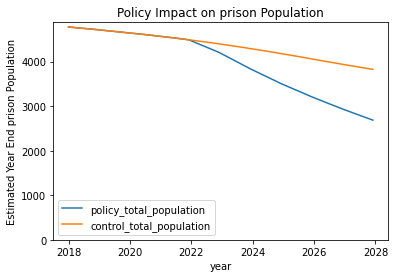

In [9]:
# Policy Option Methods
def remove_three_strikes(race, retroactive=False):
    return partial(CompartmentTransitions.use_alternate_transitions_data,
                   alternate_historical_transitions=race_data[race], 
                   retroactive=retroactive
                  )

policy_list_non_retroactive = [SparkPolicy(
            policy_fn=remove_three_strikes(race),
            spark_compartment='prison',
            sub_population={'race': race},
            apply_retroactive=False
            ) for race in races]
        
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [10]:
simulation_tag = 'IL_three_strikes'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

     year compartment     total_cost  month  day
0    2017      prison       0.000000     12    1
1    2018      prison       0.000000      1    1
2    2018      prison       0.000000      2    1
3    2018      prison       0.000000      3    1
4    2018      prison       0.000000      4    1
..    ...         ...            ...    ...  ...
355  2027   probation -604639.051365      7    1
356  2027   probation -616326.666080      8    1
357  2027   probation -627949.822289      9    1
358  2027   probation -639508.018903     10    1
359  2027   probation -651001.918225     11    1

[360 rows x 5 columns]



/Users/pacopoler/.local/share/virtualenvs/recidiviz-research-LWZgHH0n/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


     year compartment   life_years  month  day
0    2017      prison     0.000000     12    1
1    2018      prison     0.000000      1    1
2    2018      prison     0.000000      2    1
3    2018      prison     0.000000      3    1
4    2018      prison     0.000000      4    1
..    ...         ...          ...    ...  ...
355  2027   probation -2902.313884      7    1
356  2027   probation -2958.415332      8    1
357  2027   probation -3014.207374      9    1
358  2027   probation -3069.687606     10    1
359  2027   probation -3124.859205     11    1

[360 rows x 5 columns]

     year compartment                  scenario   population  month  day
0    2017      prison   policy_total_population  4774.707028     12    1
1    2018      prison   policy_total_population  4769.366026      1    1
2    2018      prison   policy_total_population  4764.064725      2    1
3    2018      prison   policy_total_population  4758.803124      3    1
4    2018      prison   policy_total_populatio